## Startup
Primeiramente são iniciados valores pré-definidos para serem usados como parâmetros.

In [1]:
"""hog"""
orientations = 9
window_dim = [153, 70]
step = [10, 10]
#6, 3
cells_per_block = [6, 3]
#3, 2
pixels_per_cell = [3, 2]
normalize_with = 'L1-sqrt'
visualize = True
desired_confidence = 0.1
scale_step = 1.10
sigma = 0.8
canny_sigma = 1


Então define-se as funções de carregar imagens, selecionar imagens aleatoriamente, mostrar imagens, e extrair as features de hog.

In [2]:
import os
from skimage.io import imread
import fnmatch

def load_dir_images(path, fltr):
    img_paths = []
    
    for root, _, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, fltr):
            img_paths.append(os.path.join(root, filename))

    images = []
    for path in img_paths:
        images.append(imread(path))
    return images

In [3]:
import matplotlib.pyplot as plt
import random as rnd
from operator import itemgetter

def select_random_images(images, ceil):
    indx = rnd.sample(range(0, len(images)), ceil)
    imgs = itemgetter(*indx)(images)
    return imgs, indx

def show(images, title = "Random images plot", ceil = 5, is_gray = False):
    im_number = len(images)
    if im_number > ceil:
        imgs = select_random_images(images, ceil)
    elif im_number == 0:
        return
    else:
        imgs = images
    fig, ax = plt.subplots(1, len(imgs), figsize=(23, 2))
    index = 0
    fig.suptitle(title)
    for image in imgs:
        if is_gray:
            ax[index].imshow(image, cmap=plt.cm.gray)
        else:
            ax[index].imshow(image)
        index += 1
    plt.show()

In [4]:
import cv2
import numpy as np

def to_gray(image):
     # If the image is colored, make a grayscale copy
    if image.shape[-1] == 3:
        gray_img = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image
    return gray_img

In [5]:
from skimage.feature import hog, canny
from operator import itemgetter
from skimage.color import rgba2rgb, rgb2gray
import skimage.filters as flt

def extract_features(images, idxs = None):
    fd = []
    imgs = []
    for img in images:
        im = flt.gaussian(img, sigma=(sigma, sigma), truncate=2., multichannel=True)
#         im = to_gray(im)
        if visualize:
            fdi, im = hog(im, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize)
            fd.append(fdi)
            imgs.append(im)
        else:
            fd.append(hog(im, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize))
    if idxs is not None and len(imgs) > max(idxs):
        show(itemgetter(*idxs)(imgs), "hog", is_gray=True)
    return fd

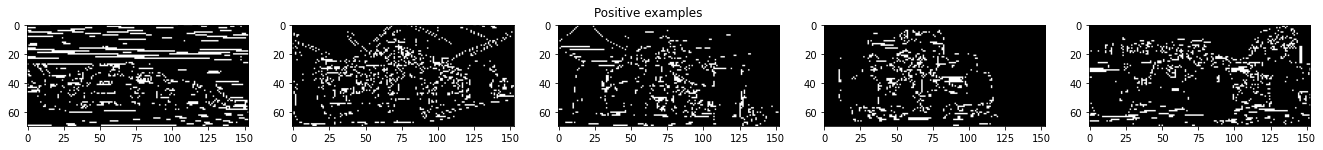

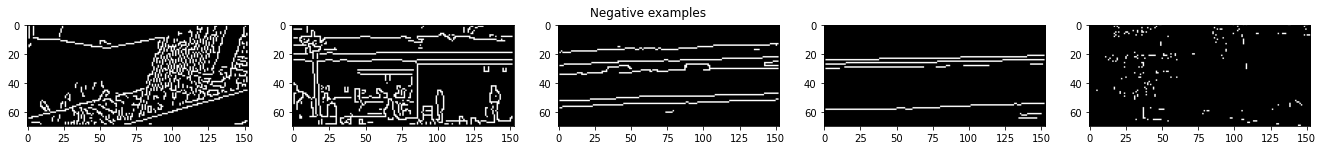

In [6]:
from skimage.transform import resize

pos = load_dir_images("../data/pos/", '*.jpg')
for i in range(0, len(pos)):
    pos[i] = canny(to_gray(pos[i]), sigma=0.75, low_threshold=75, high_threshold=90, use_quantiles=False)
    pos[i] = resize(pos[i], [70, 153])
    #image_filename = "{}.png".format(i)
    #plt.imsave(os.path.join("../data/identified/", image_filename), pos[i], cmap=plt.cm.gray)
pos_sample, pos_idx = select_random_images(pos, 5)
show(pos_sample, "Positive examples", is_gray=True)
neg = load_dir_images("../data/neg/", '*.jpg')
for i in range(0, len(neg)):
    neg[i] = canny(to_gray(neg[i]), sigma=0.75, low_threshold=75, high_threshold=90, use_quantiles=False)
    neg[i] = resize(neg[i], [70, 153])
neg_sample, neg_idx = select_random_images(neg, 5)
show(neg_sample, "Negative examples", is_gray=True)

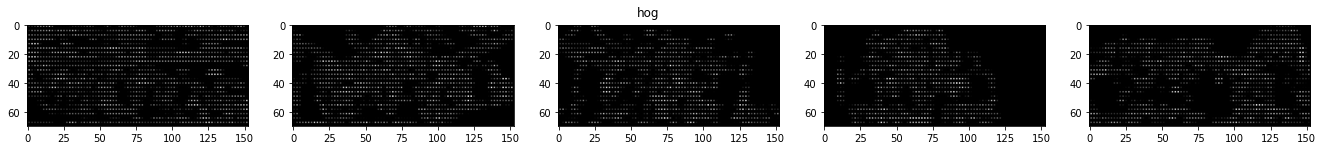

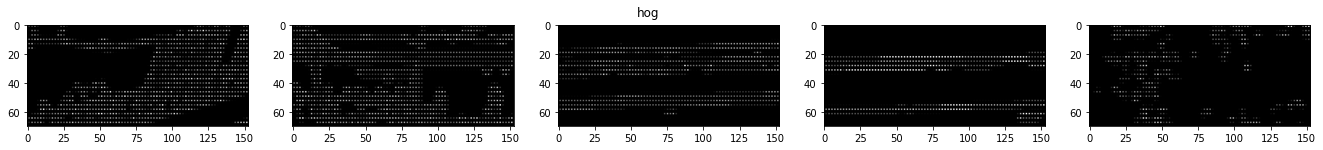

In [7]:
pos_fd = extract_features(pos, pos_idx)
neg_fd = extract_features(neg, neg_idx)

In [8]:
from sklearn.svm import LinearSVC

def train_svm(pos_fd, neg_fd):
    target = []
    features = []
    for fd in pos_fd:
        target.append(1)
        features.append(fd)

    for fd in neg_fd:
        target.append(0)
        features.append(fd)

    machine = LinearSVC(max_iter=5, tol=1e-2, verbose=1)
    machine.fit(features, target)
    return machine

In [9]:
from collections import namedtuple
Window = namedtuple("Window", "x y pixels is_border is_bottom")

def get_next_point(current, shape):
    x = current.x + step[0]
    bottom = current.is_bottom
    border = False
    if x >= shape[1] or current.is_border:
        x = 0
        y = current.y + step[1]
    elif x + window_dim[0] > shape[1]:
        x = shape[1] - window_dim[0]
        y = current.y
        border = True
    else:
        y = current.y

    if y >= shape[0] or (current.is_bottom and current.is_border):
        raise type("ImageBoundsReached", (Exception, object), {})
    elif y + window_dim[1] > shape[0]:
        y = shape[0] - window_dim[1]
        bottom = True
    return x, y, border, bottom    

In [10]:
def get_next_window(image, current=None):
    if current is None:
        x, y = 0, 0
        bottom = False
        border = False
    else:
        try:
            x, y, border, bottom = get_next_point(current, image.shape)
        except Exception:
            return None
        #x, y = current.x + step[0], current.y + step[1]
    return Window(x, y, image[y:y+window_dim[1], x:x+window_dim[0]], border, bottom)

In [11]:
def widen_search(original, scale, previous):
    if scale <= 0:
        return original
    if previous is not None: 
        if previous.shape[1] == window_dim[1] or previous.shape[0] == window_dim[0]:
            return None
    new_width = original.shape[0]//scale
    if new_width < window_dim[0]:
        scale = original.shape[0]/window_dim[0]
        new_height = original.shape[1]//scale
        return resize(original, [window_dim[0], new_height]) 
    new_height = original.shape[1]//scale
    if new_height < window_dim[1]:
        scale = original.shape[1]/window_dim[1]
        new_width = original.shape[0]//scale
        return resize(original, [new_width, window_dim[1]]) 
    return resize(original, [new_width, new_height])


In [12]:
def iou(lhs, rhs):
    lhs_tl = lhs[0:2]
    lhs_br = lhs[2:4]
    rhs_tl = rhs[0:2]
    rhs_br = rhs[2:4]
    intersec_x = max(0, min(lhs_br[0], rhs_br[0]) - max(lhs_tl[0], rhs_tl[0]))
    intersec_y = max(0, min(lhs_br[1], rhs_br[1]) - max(lhs_tl[1], rhs_tl[1]))
    intersec_area = intersec_x * intersec_y
    total_area = abs(lhs_tl[0]-lhs_br[0])*abs(lhs_tl[1]-lhs_br[1]) +\
                 abs(rhs_tl[0]-rhs_br[0])*abs(rhs_tl[1]-rhs_br[1]) -\
                 intersec_area
    return intersec_area/float(total_area)

def nms(detections, threshold):
    approved = []
    detections.sort(key=lambda item:item[4])
    while len(detections) > 0:
        current = detections[-1]
        approved.append(current)
        detections.pop()
        detections = list(filter(lambda box: iou(current, box) <= threshold, detections))
    return approved

In [13]:
def draw_vertical_line_segment(image, x, y, color, thickness):
    h_thick = thickness//2
    positions = [i for i in range(-h_thick, h_thick)]
    for pos in positions:
        new_y = y+pos
        if new_y > 0 and image.shape[1] > new_y:
            image[x, new_y] = color
    return image

def draw_horizontal_line_segment(image, x, y, color, thickness):
    h_thick = thickness//2
    h_thick = h_thick if h_thick > 0 else 1
    positions = [i for i in range(-h_thick, h_thick)] if h_thick > 1 else [0]
    for pos in positions:
        new_x = x+pos
        if new_x >= 0 and image.shape[0] > new_x:
            image[new_x, y] = color
    return image

def draw_detection(upper_point, lower_point, image, thickness):
    for x in range(upper_point[0], lower_point[0]):
        image = draw_horizontal_line_segment(image, x-1, upper_point[1], [0, 255, 0], thickness)
        image = draw_horizontal_line_segment(image, x-1, lower_point[1], [0, 255, 0], thickness)
    for y in range(upper_point[1], lower_point[1]):
        image = draw_horizontal_line_segment(image, upper_point[0]-1, y, [0, 255, 0], thickness)
        image = draw_horizontal_line_segment(image, lower_point[0]-1, y, [0, 255, 0], thickness)
    return image

In [14]:
def calculate_rectangle_centre(top_left_point, width, height):
    return top_left_point + np.array([width//2, height//2])


# def draw_centre(top_left_point, bottom_right_point, image, color=[0, 255, 0]):
#     pos = [[-1, 0], [0, -1], [0, 0], [1, 0], [0, 1]]
#     tlp = np.array(top_left_point)
#     brp = np.array(bottom_right_point)
#     w, h = brp - tlp
#     x_c, y_c = calculate_rectangle_centre(tlp, w, h)
#     for p in pos:
#         x = x_c + p[0]
#         y = y_c + p[1]
#         if x >= 0 and x < image.shape[0] and y >= 0 and y < image.shape[1]:
#             image[x, y] = color
#     return image


def calculate_centre_range(top_left_point, width, height):
    centre = calculate_rectangle_centre(top_left_point, width, height)
    fourth = np.array([width//4, height//4])
    tr_x, tr_y = centre - fourth
    bl_x, bl_y = centre + fourth
    return np.array([tr_x, tr_y, bl_x, bl_y])

def is_point_within(point, rect):
    x_within = point[0] > rect[0] and point[0] < rect[2]
    y_within = point[1] > rect[1] and point[1] < rect[3]
    return x_within and y_within

def are_semi_concentric(rect_a, rect_b):
    tlp_a = np.array([rect_a[0], rect_a[1]])
    brp_a = np.array([rect_a[2], rect_a[3]])
    
    tlp_b = np.array([rect_b[0], rect_b[1]])
    brp_b = np.array([rect_b[2], rect_b[3]])
    
    w_a, h_a = brp_a - tlp_a
    centre_range = calculate_centre_range(tlp_a, w_a, h_a)
    w_b, h_b = brp_b - tlp_b
    b_centre = calculate_rectangle_centre(tlp_b, w_b, h_b)
    return is_point_within(b_centre, centre_range)

In [15]:
# import numpy as np
# import os
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# import time

# test = load_dir_images("../data/test/", '*.jpg')
# boxes = []
# def valor(source):
#     classify_svm(machine, test[source], 0, False)            

# def classify_svm(machine, image, count, verbose=False):
#     im = None
#     img = None
#     scale = scale_step
#     maximum = 0
#     turn = 0
#     fitting_im = to_gray(image)
#     fitting_im = canny(fitting_im, sigma=0.75, low_threshold=75, high_threshold=90, use_quantiles=False)
#     while((img := widen_search(fitting_im, scale**turn, img)) is not None):
#         img = flt.gaussian(img, sigma=(sigma, sigma), truncate=2., multichannel=True)
#         print(img.shape)
#         start = time.time()
#         while((im := get_next_window(img, im)) is not None):
#             if verbose:
#                 print("Running with window at ({}, {}) up to ({},{})".format(im.x,
#                                                                          im.y,
#                                                                          im.pixels.shape[1]+im.x,
#                                                                          im.pixels.shape[0]+im.y))
#             if visualize and verbose:
#                 result = hog(im.pixels, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize)
#                 feat, im_hog = result
#                 show([im_hog, im.pixels], "hog", 2, True)
#             else:
#                 feat = hog(im.pixels, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize and verbose)
#             feat = np.array(feat).reshape(1, (len(feat)))
#             prediction = machine.predict(feat)
#             confidence = machine.decision_function(feat)
#             maximum = confidence if maximum < confidence else maximum
#             if prediction == 1 and confidence >= desired_confidence:
#                 if verbose:
#                     print("Found one at ({},{}) up to ({},{})".format(im.x,
#                                                                       im.y,
#                                                                       im.pixels.shape[1]+im.x,
#                                                                       im.pixels.shape[0]+im.y))
#                 image_filename_2 = "{}_or.png".format(confidence)
#                 in_y = im.y
#                 in_x = im.x
#                 scl = scale**turn
#                 plt.imsave(os.path.join("../data/identified/", image_filename_2), 
#                                image[int(in_y*scl):int((in_y+im.pixels.shape[0])*scl),
#                                      int(in_x*scl):int((in_x+im.pixels.shape[1])*scl)])
#                 #show([im_hog, im.pixels], "hog", 2, True)
#                 #plt.show()
#                 box = (int(in_y*scl), int(in_x*scl),
#                        int((in_y+im.pixels.shape[0])*scl),
#                        int((in_x+im.pixels.shape[1])*scl), confidence)
                
#                 boxes.append(box)
#                 image_filename = "{}.png".format(confidence)
# #                 plt.imsave(os.path.join("../data/identified/", image_filename), im.pixels)
#         print("\nPrediction time for image {}: {}".format(turn, time.time()-start))
#         turn += 1
#     image_copy = np.copy(image)
#     for box in boxes:
#         image_copy = draw_detection((box[0], box[1]), (box[2], box[3]), image_copy, 3)
#     plt.imshow(image_copy)
#     plt.show()
#     approved = nms(boxes, 0.4)
#     image_copy = np.copy(image)
#     no_concentric = []
#     for box in approved:
#         image_copy = draw_detection((box[0], box[1]), (box[2], box[3]), image_copy, 3)
#     plt.imshow(image_copy)
#     plt.imsave(os.path.join("../data/identified/", "final.png"), image_copy)
#     for i, box1 in enumerate(approved):
#         valid = True
#         j = 0
#         while valid and j < len(approved):
#             box2 = approved[j]
#             if not box1 == box2 and\
#                 are_semi_concentric(box1, box2) and\
#                 box1[4] < box2[4]:
#                     valid = False
#             j += 1
#         if valid:
#             no_concentric.append(box1)
#     image_copy = np.copy(image)
#     for box in no_concentric:
#         image_copy = draw_detection((box[0], box[1]), (box[2], box[3]), image_copy, 3)
#     plt.imshow(image_copy)
#     plt.imsave(os.path.join("../data/identified/", "final_2.png"), image_copy)

# sources = [i for i in range(0, len(test))]
# test_cases = len(test)
# start = time.time()
# machine = train_svm(pos_fd, neg_fd)
# print("\nTotal training time: {}".format(time.time()-start))
# selected_test_case = rnd.randint(0, test_cases)
# show(test, "test cases", len(test))
# interact_manual(valor, source=sources)

[LibLinear]

/home/lucasneis/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


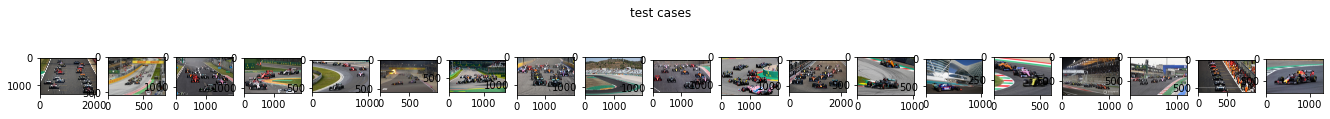

interactive(children=(Dropdown(description='source', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

In [49]:
import numpy as np
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time


test = load_dir_images("../data/test/", '*.jpg')
result = None
machine = train_svm(pos_fd, neg_fd)


class Storer:
    def store_subimage(self, image, rectangle, directory, name):
        pass
    
    
    def store_image(self, image, directory, name):
        pass
    
    
    def save_subimage(self, image, rectangle, directory, name):
        subimage = image[rectangle[1]:rectangle[3],
                         rectangle[0]:rectangle[2]]
        plt.imsave(os.path.join(directory, name), subimage)
    
    def save_image(self, image, directory, name):
        plt.imsave(os.path.join(directory, name), image)


class TrueStorer(Storer):
    def store_subimage(self, image, rectangle, directory, name):
        super.save_subimage(image, rectangle, directory, name)


    def store_image(self, image, directory, name):
        super.save_image(image, directory, name)


def save_chosen(chosen):
    result = classify(machine, test[chosen], 0, False, TrueStorer())


def valor(source):
    save_chosen(source)

def classify(machine, image, count, verbose=False, storer=Storer):
    img = None
    scale = scale_step
    turn = 0
    fitting_im = to_gray(image)
    fitting_im = canny(fitting_im, sigma=0.75, low_threshold=75,
                       high_threshold=90, use_quantiles=False)
    boxes = []
    while((img := widen_search(fitting_im, curr_scl := scale**turn, img)) is not None):
        boxes = search_image(image, img, sigma, curr_scl, boxes, storer, verbose)
        turn += 1
    marked_up = draw_all_detections_on_image(boxes, image)
    plt.imshow(marked_up)
    plt.show()
    storer.save_image(marked_up, "../data/identified/", "found_by_svm.jpg")

    nms_result = nms(boxes, 0.4)
    marked_up = draw_all_detections_on_image(nms_result, image)
    plt.imshow(marked_up)
    plt.show()
    storer.save_image(marked_up, "../data/identified/", "cleaned_by_nms.jpg")

    remove_concentric(nms_result)
    marked_up = draw_all_detections_on_image(nms_result, image)
    plt.imshow(marked_up)
    plt.show()
    storer.save_image(marked_up, "../data/identified/", "extra_cleaned.jpg")
    return marked_up


def search_image(original, image, gaussian_sigma, current_scale, predicted, storer, verbose=False):
    image = flt.gaussian(image, sigma=(gaussian_sigma, gaussian_sigma),
                         truncate=2., multichannel=True)
    window = None
    while((window := get_next_window(image, window)) is not None):
        predicted = run_prediction_on_window(original, window, current_scale, predicted, storer, verbose)
    return predicted


def run_prediction_on_window(original, window, scale, predicted, storer, verbose=False):
    hog_op = verbose_hog if visualize and verbose else clean_hog
    feat = hog_op(window.pixels, orientations, pixels_per_cell,
                  cells_per_block, normalize_with)
    prediction = machine.predict(feat)
    confidence = machine.decision_function(feat)
    if prediction_valid(prediction, confidence, desired_confidence):
        height, width = window.pixels.shape
        top_left = (window.x, window.y)
        bottom_right = (window.x+width, window.y+height)
        win_rect = calculate_rectangle(top_left, bottom_right, scale)
        storer.save_subimage(original, win_rect, "../data/identified/", "{}.jpg".format(confidence))
        predicted.append(create_confidence_box(win_rect, confidence))
    return predicted


def verbose_hog(im, orientations, ppc, cpb, normalization):
    result = hog(im, orientations, ppc, cpb, normalization, True)
    feat, im_hog = result
    show([im_hog, im], "hog", 2, True)
    return np.array(feat).reshape(1, (len(feat)))


def clean_hog(im, orientations, ppc, cpb, normalization):
    result = hog(im, orientations, pixels_per_cell,
                 cells_per_block, normalize_with, False)
    return np.array(result).reshape(1, (len(result)))


def prediction_valid(prediction, confidence, desired):
    return prediction == 1 and confidence >= desired


def calculate_rectangle(top_left, bottom_right, scale):
    tlx, tly = top_left
    brx, bry = bottom_right
    return np.int32((tlx*scale, tly*scale, brx*scale, bry*scale))


def create_confidence_box(rectangle, confidence):
    x1, y1, x2, y2 = rectangle
    return (x1, y1, x2, y2, confidence)


def draw_all_detections_on_image(detections, original_image):
    image_copy = np.copy(original_image)
    for box in detections:
        image_copy = draw_detection(
            (box[1], box[0]), (box[3], box[2]), image_copy, 3)
    return image_copy


def remove_concentric(approved):
    clean = []
    for i, box1 in enumerate(approved):
        valid = True
        j = 0
        while valid and j < len(approved):
            box2 = approved[j]
            concentric = box1 != box2 and\
                are_semi_concentric(box1, box2) and\
                box1[4] < box2[4]
            if concentric:
                valid = False
            j += 1
        if valid:
            clean.append(box1)
    return clean


def run_classify():
    sources = [i for i in range(0, len(test))]
    test_cases = len(test)
    selected_test_case = rnd.randint(0, test_cases)
    show(test, "test cases", len(test))
    interact_manual(valor, source=sources)

run_classify()
